In this notebook we apply pyMAISE to a 2D rod ejection data set. Our discussion is limited to the methods and models we apply and does not include an in-depth discussion of pyMAISE. For an in-depth tutorial, refer to the [MIT Reactor](https://pymaise.readthedocs.io/en/stable/examples/mit_reactor.html) notebook. For information on the pyMAISE methods used, refer to the [pyMAISE API reference documentation](https://pymaise.readthedocs.io/en/stable/pymaiseapi/index.html).

# Reactor Physics

**Inputs**: 2-group homogenized cross sections (HXS) ($cm^{-1}$)

- `FissionFast`: $\nu\Sigma_f^1$
- `CaptureFast`: $\Sigma_a^1$
- `FissionThermal`: $\nu\Sigma_f^2$
- `CaptureThermal`: $\Sigma_a^2$
- `Scatter12`: $\Sigma_s^{1 \rightarrow 2}$
- `Scatter11`: $\Sigma_s^{1 \rightarrow 1}$
- `Scatter21`: $\Sigma_s^{2 \rightarrow 1}$
- `Scatter22`: $\Sigma_s^{2 \rightarrow 2}$

**Outputs**

- `k`: Neutron multipulcation factor

This data set consists of 1000 observations with 8 inputs and 1 output. The data is taken from [1], a sensitivity analysis using the Shapley effect. The geometry of the problem is a pressurized water reactor (PWR) lattice based on the BEAVRS benchmark. The lattice is a $17 \times 17$ PWR with $264~UO_2$ fuel rods, 24 guide tubes, and one instrumentation tube. The lattice utilizes quarter symmetry in TRITON and is depleted to $50~GWD/MTU$. To construct the data set, a two-step process was used: (1) the uncertainty in the fundamental microscopic XS data was propagated, and (2) these XSs were collapsed into a 2-group form using the following equation

\begin{equation}
\Sigma_x^g = \frac{\int_{\Delta E_g}dE \int_V \Sigma_{x,m}(E) \phi(r,E,t) dV}{\int_{\Delta E_g}dE\int_V\phi(r,E,t)dV}.
\end{equation}

The sampler module in SCALE was used for uncertainty propagation, and the 56-group XS and covariance libraries were used in TRITON to create 56-group HXSs using the above equation. These HXSs are then collapsed into a 2-group library. 1000 random samples were taken from the Sampler [[RSOGradyK19]](https://pymaise.readthedocs.io/en/stable/index.html#id3).

To start pyMAISE the general packages are imported below.

In [1]:
from pyMAISE.datasets import load_xs
from pyMAISE.preprocessing import correlation_matrix, train_test_split, scale_data
import pyMAISE as mai

import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint
from sklearn.preprocessing import MinMaxScaler

# Plot settings
matplotlib_settings = {
    "font.size": 12,
    "legend.fontsize": 11,
    "figure.figsize": (8, 8)
}
plt.rcParams.update(**matplotlib_settings)

Using TensorFlow backend


2024-01-14 11:47:27.701187: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 11:47:27.764613: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 11:47:27.766176: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-14 11:47:28.452930: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


We can load the reactor physics pre-processor by `load_xs()` and with defining the it is a regression problem below.

In [2]:
global_settings = mai.init(
    problem_type=mai.ProblemType.REGRESSION,   # Define a regression problem
    cuda_visible_devices="-1"                  # Use CPU only
)
data, inputs, outputs = load_xs()

The data consists of 8 inputs:

In [3]:
inputs

<xarray.DataArray (index: 1000, variable: 8)>
array([[0.0064462 , 0.00924782, 0.130007  , ..., 0.482483  , 0.00150595,
        1.12546   ],
       [0.00635893, 0.00934703, 0.128811  , ..., 0.490558  , 0.00149675,
        1.12616   ],
       [0.0064674 , 0.00925333, 0.129465  , ..., 0.486784  , 0.00149345,
        1.12423   ],
       ...,
       [0.00649919, 0.00934518, 0.129862  , ..., 0.490898  , 0.00151782,
        1.1289    ],
       [0.00647664, 0.00944998, 0.130726  , ..., 0.494716  , 0.0015138 ,
        1.12734   ],
       [0.0062723 , 0.00960541, 0.130317  , ..., 0.502067  , 0.00150592,
        1.1264    ]])
Coordinates:
  * index     (index) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
  * variable  (variable) object 'FissionFast' 'CaptureFast' ... 'Scatter22'

and one output with 1000 data points:

In [4]:
outputs

<xarray.DataArray (index: 1000, variable: 1)>
array([[1.256376],
       [1.241534],
       [1.256988],
       [1.261442],
       [1.253744],
       [1.261324],
       [1.246886],
       [1.249954],
       [1.25212 ],
       [1.258008],
       [1.256793],
       [1.247149],
       [1.253193],
       [1.249416],
       [1.24956 ],
       [1.246953],
       [1.248573],
       [1.261022],
       [1.247053],
       [1.249361],
...
       [1.256116],
       [1.239636],
       [1.269848],
       [1.249036],
       [1.24979 ],
       [1.262373],
       [1.256964],
       [1.246652],
       [1.250859],
       [1.251616],
       [1.251508],
       [1.25897 ],
       [1.259301],
       [1.247735],
       [1.244721],
       [1.256407],
       [1.24553 ],
       [1.251895],
       [1.255878],
       [1.240064]])
Coordinates:
  * index     (index) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
  * variable  (variable) object 'k'

To get a better idea of the data we can create a corrilation matrix using the `correlation_matrix()` function.

(<Figure size 800x800 with 2 Axes>, <AxesSubplot:>)

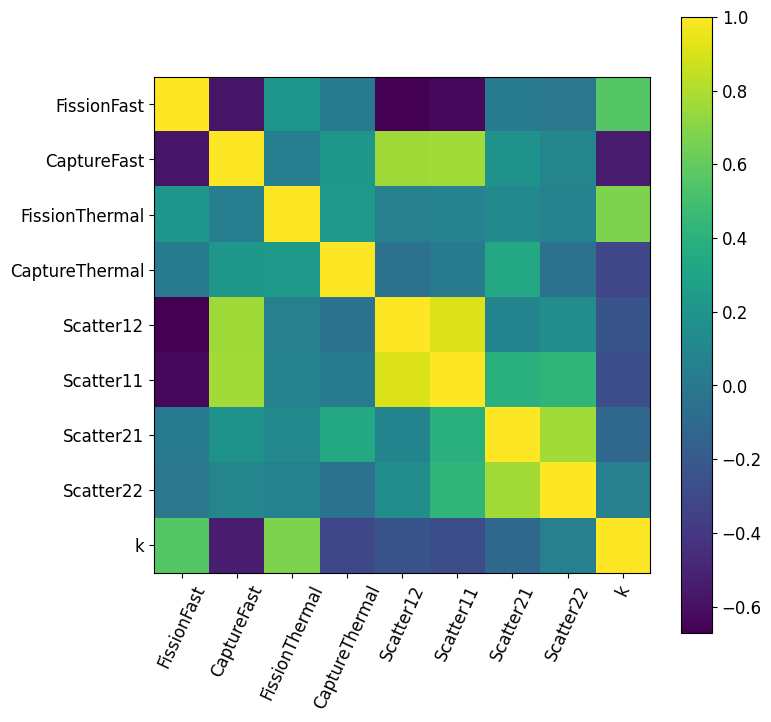

In [5]:
correlation_matrix(data)

There is a positive correlation between `k` with `FissionFast` and `FissionThermal`.

The last step of initialization is scaling, we will min-max scale this data.

In [6]:
xtrain, xtest, ytrain, ytest = train_test_split(data=[inputs, outputs], test_size=0.3)
xtrain, xtest, xscaler = scale_data(xtrain, xtest, scaler=MinMaxScaler())
ytrain, ytest, yscaler = scale_data(ytrain, ytest, scaler=MinMaxScaler())

## Model Initialization

We will examine the performance of 6 regression models in this data set:

- linear: `Linear`,
- lasso: `Lasso`,
- decision tree: `DT`,
- random forest: `RF`,
- k-nearest neighbors regression: `KN`,
- dense feedforward neural network: `FNN`.

For hyperparameter tuing, we initialize all classical models as scikit-learn defaults. For the FNN we define input and output layers with possible dropout layers. These layers include hyperparameter tuning of their number of nodes, use of sublayer, and the rate of dropout. The dense hidden layers include tuning of their depth.

In [7]:
model_settings = {
    "models": ["Linear", "Lasso", "DT", "RF", "KN", "FNN"],
    "FNN": {
        "structural_params": {
            "Dense_input": {
                "units": mai.Int(min_value=50, max_value=400),
                "input_dim": xtrain.shape[-1],
                "activation": "relu",
                "kernel_initializer": "normal",
                "sublayer": mai.Choice(["Dropout", "None"]),
                "Dropout": {
                    "rate": mai.Float(min_value=0.4, max_value=0.6),
                },
            },
            "Dense_hidden": {
                "num_layers": mai.Int(min_value=0, max_value=3),
                "units": mai.Int(min_value=25, max_value=250),
                "activation": "relu",
                "kernel_initializer": "normal",
                "sublayer": mai.Choice(["Dropout_hidden", "None"]),
                "Dropout_hidden": {
                    "rate": mai.Float(min_value=0.4, max_value=0.6),
                },
            },
            "Dense_output": {
                "units": ytrain.shape[-1],
                "activation": "linear",
                "kernel_initializer": "normal",
            },
        },
        "optimizer": "Adam",
        "Adam": {
            "learning_rate": mai.Float(min_value=1e-5, max_value=0.001),
        },
        "compile_params": {
            "loss": "mean_absolute_error",
            "metrics": ["mean_absolute_error"],
        },
        "fitting_params": {
            "batch_size": mai.Choice([8, 16, 32]),
            "epochs": 50,
            "validation_split": 0.15,
        },
    },
}
tuner = mai.Tuner(xtrain, ytrain, model_settings=model_settings)

## Hyper-parameter Tuning

They hyper-parameter tuning spaces are defined below. We use random search for the classical models as their training is quick and random search can cover a large parameter space. Bayesian search is used for the neural networks as their training is more computationally expensive. Both search methods use 5-fold cross-validation to mitigate bias from the training data. We train 300 classical models from random search and 50 iterations of Bayesian search for neural networks. 

In [8]:
random_search_spaces = {
    "Lasso": {
        "alpha": uniform(loc=0.0001, scale=0.0099), # 0.0001 - 0.01
    },
    "DT": {
        "max_depth": randint(low=5, high=50), # 5 - 50
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
    },
    "RF": {
        "n_estimators": randint(low=50, high=200), # 50 - 200
        "criterion": ["squared_error", "absolute_error", "poisson"],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
    },
    "KN": {
        "n_neighbors": randint(low=1, high=20), # 1 - 20
        "weights": ["uniform", "distance"],
        "leaf_size": randint(low=1, high=30), # 1 - 30
        "p": randint(low=1, high=10), # 1 - 10
    },
}
start = time.time()
random_search_configs = tuner.random_search(
    param_spaces=random_search_spaces, 
    n_iter=200, 
    cv=5,
)
bayesian_search_configs = tuner.nn_bayesian_search(
    objective="r2_score",
    max_trials=50,
    cv=5,
)
print("Hyperparameter tuning took " + str((time.time() - start) / 60) + " minutes to process.")

Trial 50 Complete [00h 00m 12s]
r2_score: 0.9670107182064441

Best r2_score So Far: 0.9995071388117088
Total elapsed time: 00h 12m 15s
Hyperparameter tuning took 15.912196775277456 minutes to process.


We can now see the Bayesian search hyper-parameter optimization in the convergence plot.

(0.0, 1.0)

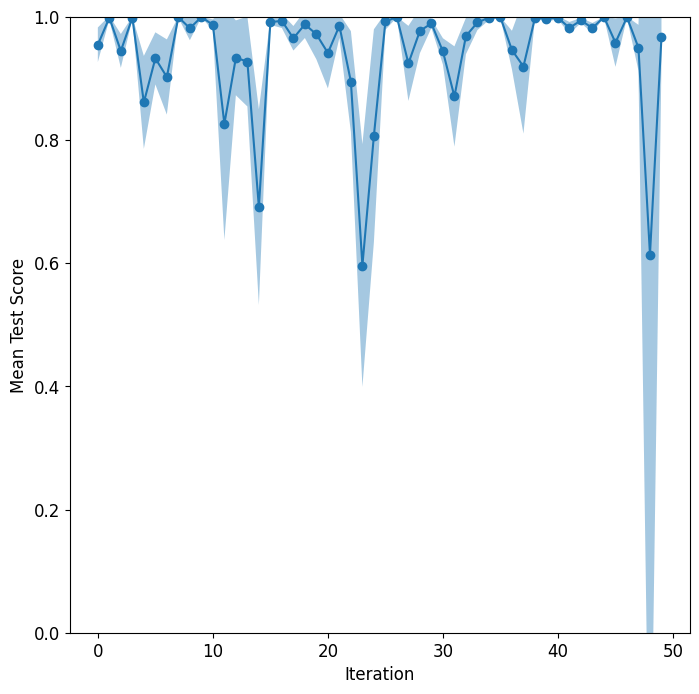

In [36]:
ax = tuner.convergence_plot(model_types="FNN")
ax.set_ylim([0, 1])

It appears to converge at around the 10th iteration.

## Model Post-processing

With the top `num_configs_saved`, we can pass these parameter configurations to the `PostProcessor` for model comparison and analysis. For `nn` we define the `epochs` parameter to be 200 for better performance.

In [46]:
postprocessor = mai.PostProcessor(
    data=(xtrain, xtest, ytrain, ytest), 
    model_configs=[random_search_configs, bayesian_search_configs], 
    new_model_settings={
        "FNN": {"epochs": 200},
    },
    yscaler=yscaler,
)

To compare the performance of these models we will compute 4 metrics for both the training and testing data: 

- mean squared error `MSE` $=\frac{1}{n}\sum^n_{i = 1}(y_i - \hat{y_i})^2$, 
- root mean squared error `RMSE` $=\sqrt{\frac{1}{n}\sum^n_{i = 1}(y_i - \hat{y_i})^2}$,
- mean absolute error `MAE` = $=\frac{1}{n}\sum^n_{i = 1}|y_i - \hat{y_i}|$,
- and r-squared `R2` $=1 - \frac{\sum^n_{i = 1}(y_i - \hat{y_i})^2}{\sum^n_{i = 1}(y_i - \bar{y_i})^2}$,

where $y$ is the actual outcome, $\bar{y}$ is the average outcome, $\bar{y}$ is the model predicted outcome, and $n$ is the number of observations.

The metrics for each unique output feature are shown below.

In [47]:
postprocessor.metrics()

,Model Types,Parameter Configurations,Train R2,Train MAE,Train MSE,Train RMSE,Test R2,Test MAE,Test MSE,Test RMSE
0,Linear,"{'copy_X': True, 'fit_intercept': True, 'n_job...",0.999925,0.000045,4.088870e-09,0.000064,0.999933,0.000041,3.399570e-09,0.000058
24,FNN,"{'Dense_input_0_units': 230, 'Dense_input_0_su...",0.999707,0.000052,1.607506e-08,0.000127,0.999500,0.000059,2.552977e-08,0.000160
21,FNN,"{'Dense_input_0_units': 318, 'Dense_input_0_su...",0.999711,0.000091,1.583698e-08,0.000126,0.999454,0.000097,2.787685e-08,0.000167
1,Lasso,{'alpha': 0.00016597415760731229},0.999471,0.000134,2.900492e-08,0.000170,0.999447,0.000136,2.821955e-08,0.000168
2,Lasso,{'alpha': 0.00018051283858992338},0.999390,0.000144,3.347879e-08,0.000183,0.999362,0.000146,3.256989e-08,0.000180
23,FNN,"{'Dense_input_0_units': 340, 'Dense_input_0_su...",0.999593,0.000118,2.232023e-08,0.000149,0.999263,0.000128,3.761946e-08,0.000194
3,Lasso,{'alpha': 0.00019612897697265106},0.999295,0.000156,3.870214e-08,0.000197,0.999262,0.000158,3.764432e-08,0.000194
4,Lasso,{'alpha': 0.000211133937190697},0.999196,0.000166,4.412901e-08,0.000210,0.999159,0.000168,4.291219e-08,0.000207
5,Lasso,{'alpha': 0.00021396734193176222},0.999176,0.000168,4.519873e-08,0.000213,0.999139,0.000171,4.395011e-08,0.000210
22,FNN,"{'Dense_input_0_units': 278, 'Dense_input_0_su...",0.999070,0.000179,5.102949e-08,0.000226,0.999116,0.000177,4.511650e-08,0.000212


When looking at the averaged metrics top performing models are `Linear`, `FNN` and `Lasso` based off the r-squared values. This makes sense as tree models will not perform as well on linear datasets.

We can see the hyper-parameter configurations of each top `Test R2` model with the `get_params` function.

In [59]:
for model in ["Lasso", "DT", "RF", "KN", "FNN"]:
    for key, value in postprocessor.get_params(model_type=model).to_dict().items():
        print(f"{key}: {value[0]}")
    print()

Model Types: Lasso
alpha: 0.00016597415760731229

Model Types: DT
max_depth: 30
max_features: None
min_samples_leaf: 8
min_samples_split: 13

Model Types: RF
criterion: squared_error
max_features: 6
min_samples_leaf: 1
min_samples_split: 4
n_estimators: 78

Model Types: KN
leaf_size: 13
n_neighbors: 6
p: 4
weights: distance

Model Types: FNN
Dense_input_0_units: 230
Dense_input_0_sublayer: None
Dense_input_0_sublayer_Dropout_0_rate: 0.45985655789406166
Dense_hidden_num_layers: 2
Adam_learning_rate: 8.486824738596939e-05
Dense_hidden_0_units: 165
Dense_hidden_0_sublayer: None
Dense_hidden_0_sublayer_Dropout_hidden_0_rate: 0.5173106548906062
batch_size: 8
Dense_hidden_1_units: 49
Dense_hidden_1_sublayer: None
Dense_hidden_1_sublayer_Dropout_hidden_0_rate: 0.4716057924801158
Dense_hidden_2_units: 77
Dense_hidden_2_sublayer: Dropout_hidden
Dense_hidden_2_sublayer_Dropout_hidden_0_rate: 0.5764712103505741



We can better visualize the performance of each model with diagonal validation plots. This can be done for each output feature. In this case we will look at `k`.

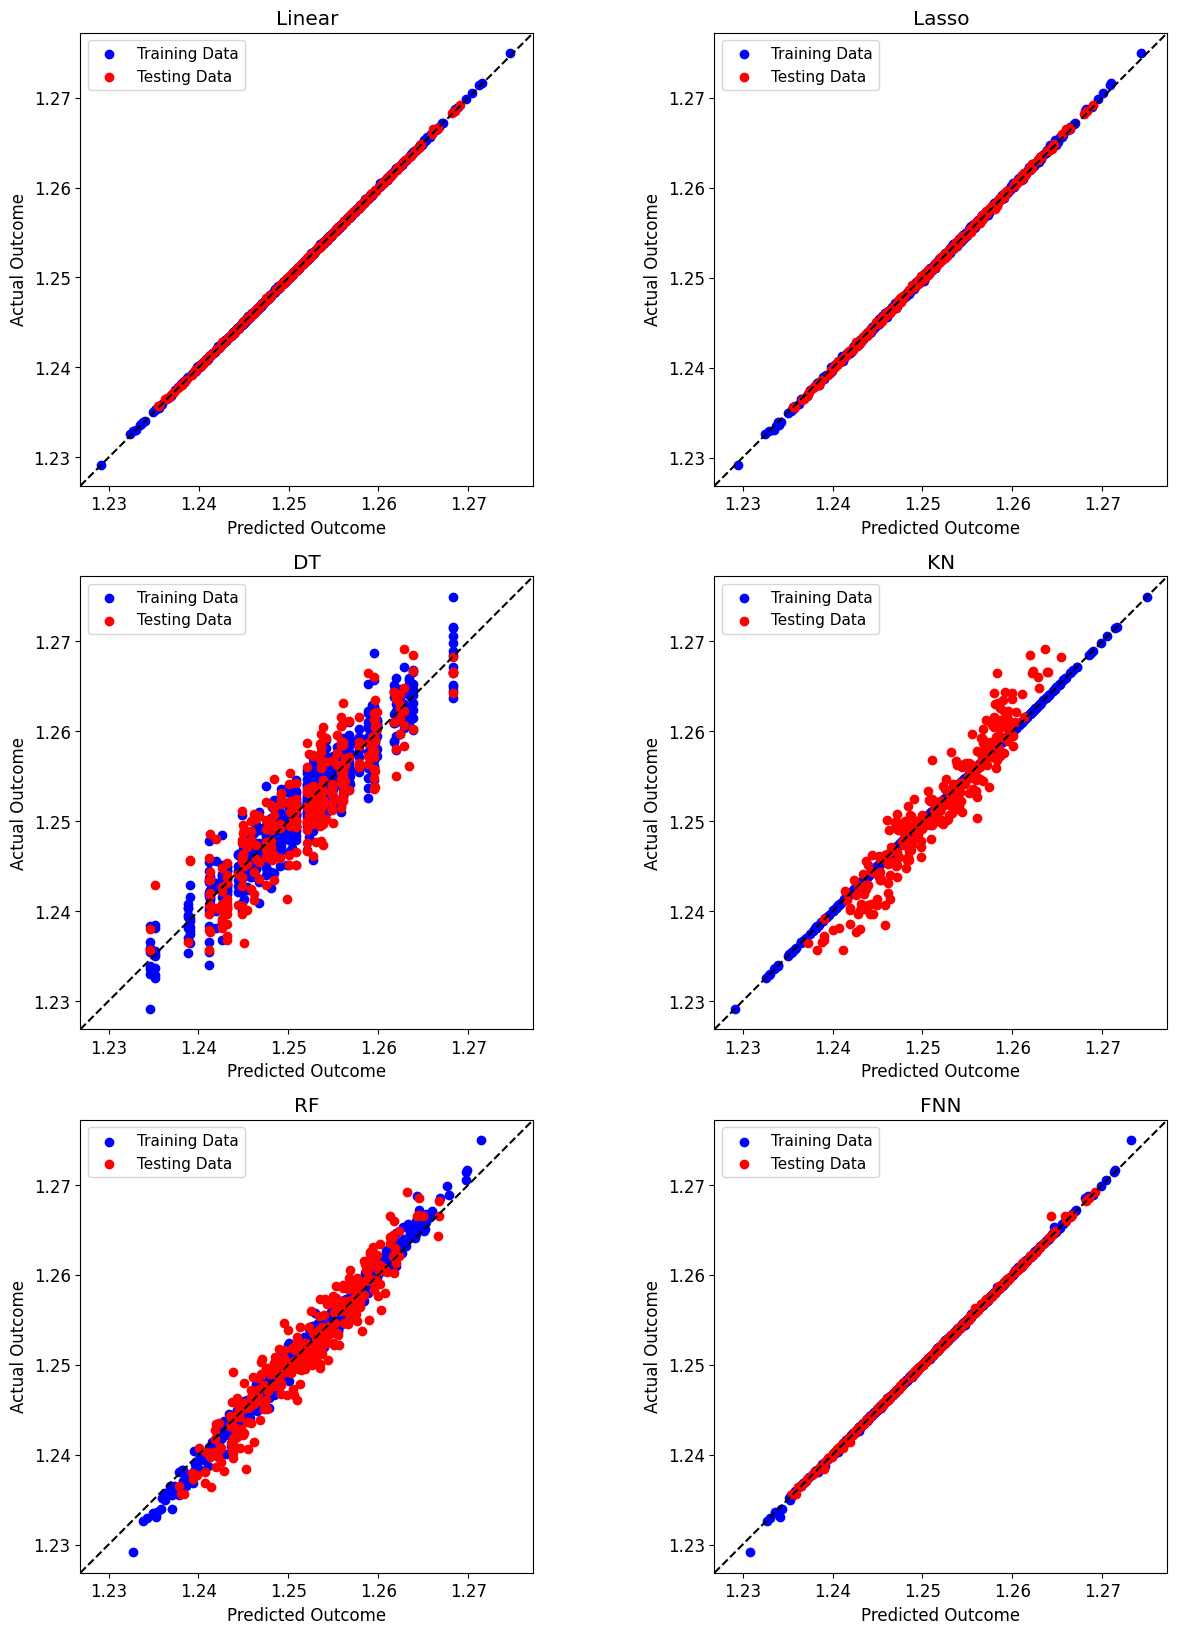

In [60]:
def performance_plot(meth, output):
    models = np.array([["Linear", "Lasso"], ["DT", "KN"], ["RF", "FNN"]])
    fig, axarr = plt.subplots(models.shape[0], models.shape[1], figsize=(15,20))
    for i in range(models.shape[0]):
        for j in range(models.shape[1]):
            plt.sca(axarr[i, j])
            axarr[i, j] = meth(model_type=models[i, j], y=[output])
            axarr[i, j].set_title(models[i, j])


performance_plot(postprocessor.diagonal_validation_plot, "k")

`Linear`, `Lasso`, and `FNN` are tightly spread near $y = x$. The overfit of `KN` is apparent in the difference in spread of training compared to testing.

Validation plots tell us a similar story.

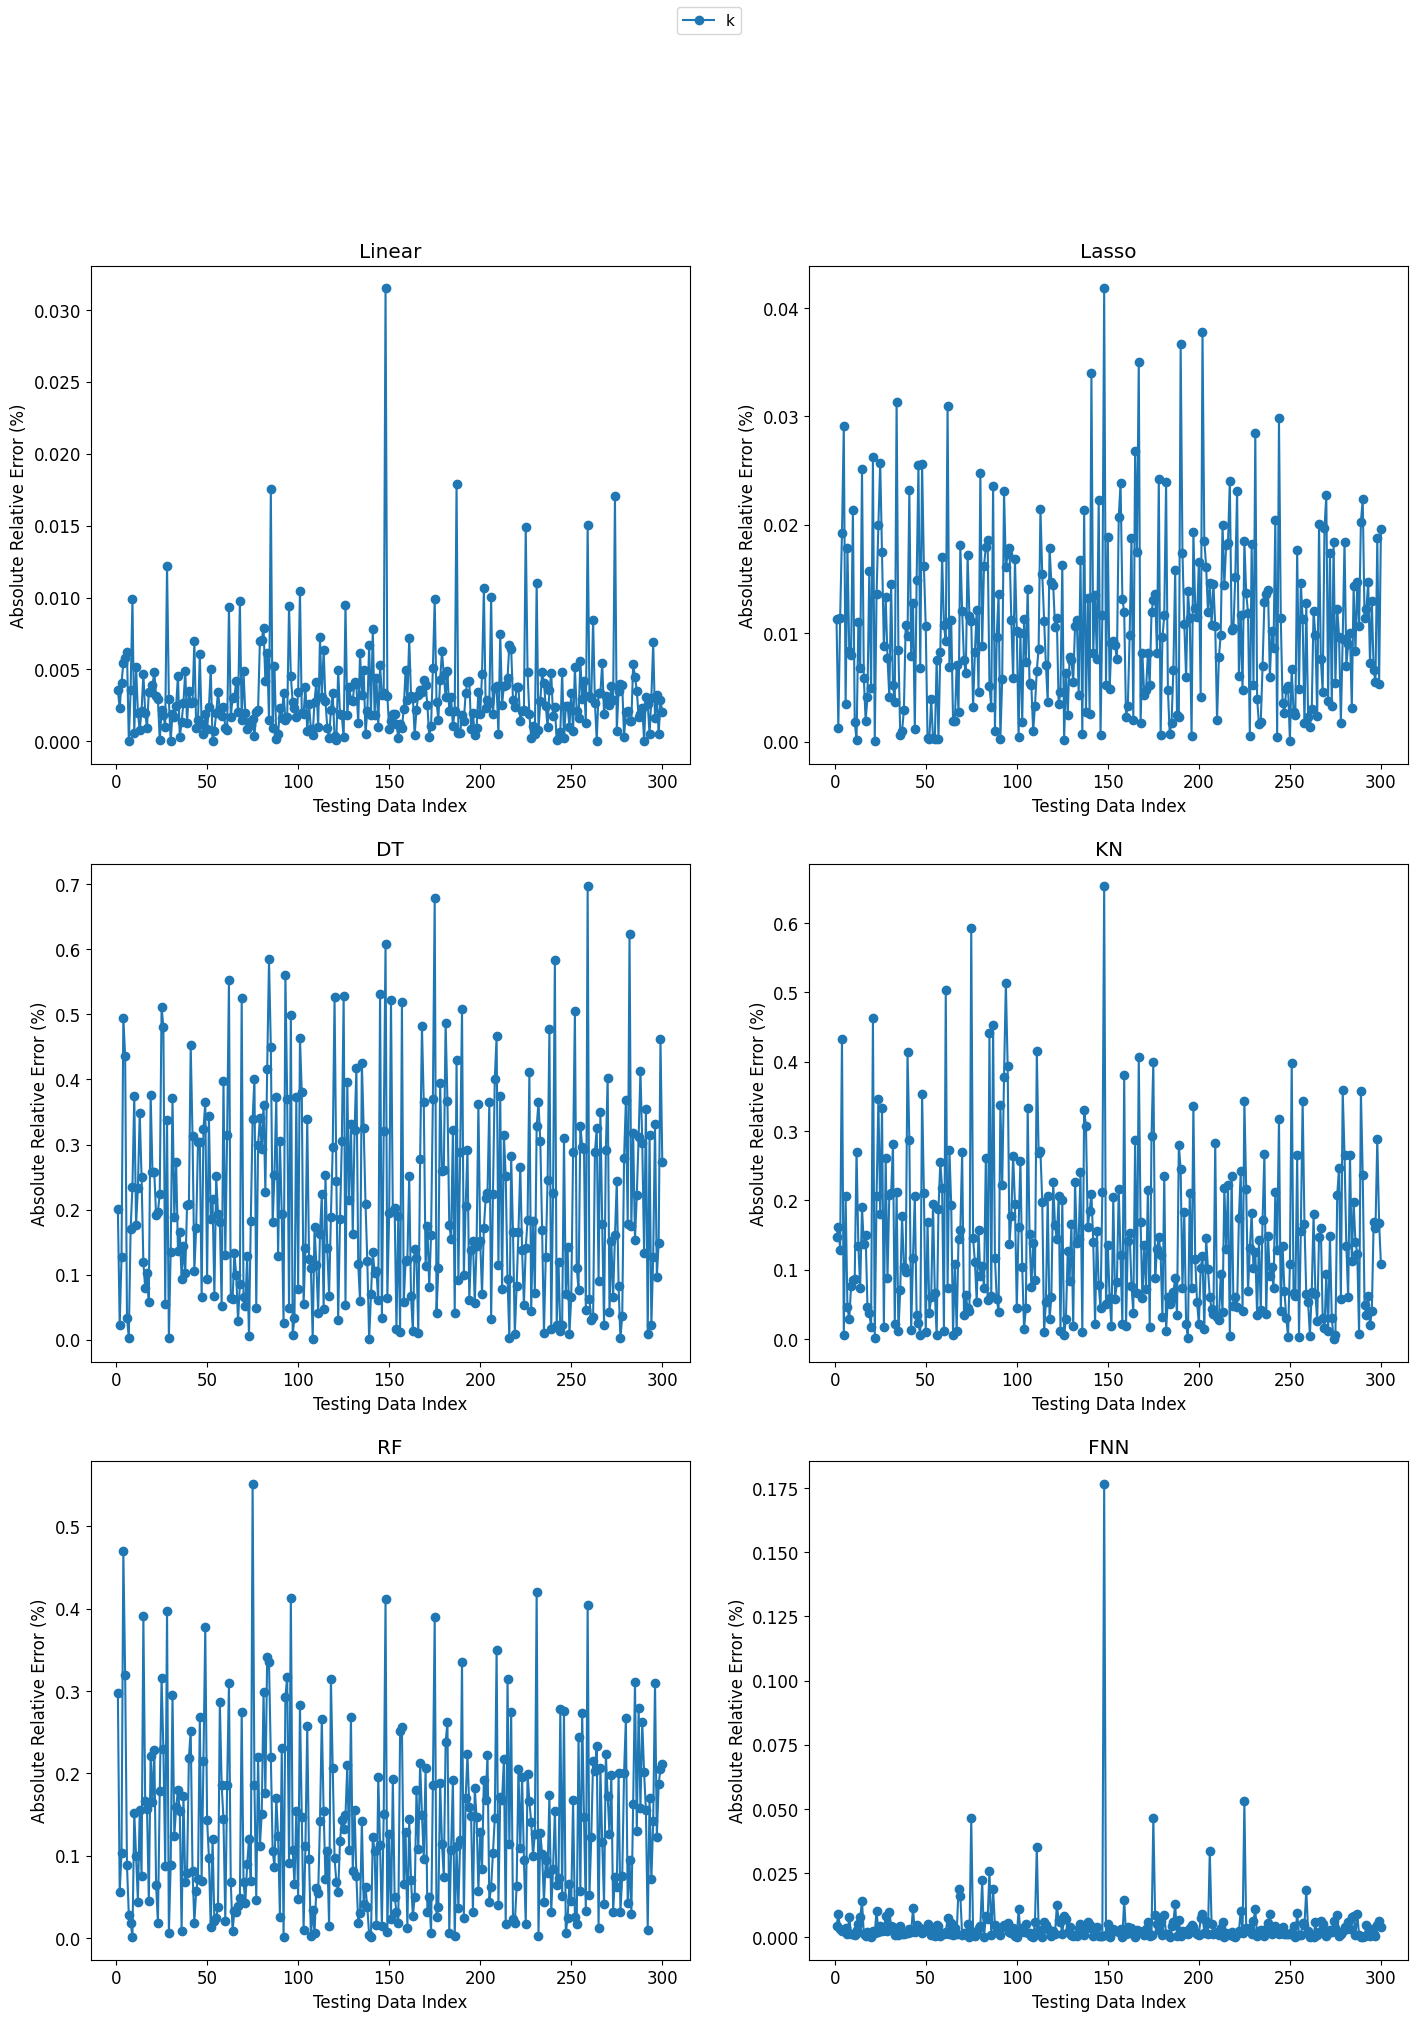

In [61]:
fig, axarr = plt.subplots(models.shape[0], models.shape[1], figsize=(17,22))

y = ["k"]

for i in range(models.shape[0]):
    for j in range(models.shape[1]):
        plt.sca(axarr[i, j])
        axarr[i, j] = postprocessor.validation_plot(model_type=models[i, j], y=y)
        axarr[i, j].set_title(models[i, j])

fig.legend(y, loc="upper center", ncol=4)

`Linear`, `Lasso`, and `FNN` have all testing relative errors less than 0.10.

Finally, we can see if `FNN` was overfit in learning curves.

In [62]:
postprocessor.nn_learning_plot()

AssertionError: 

The validation curve is below the training curve; therefore, this `nn` was not overfit.

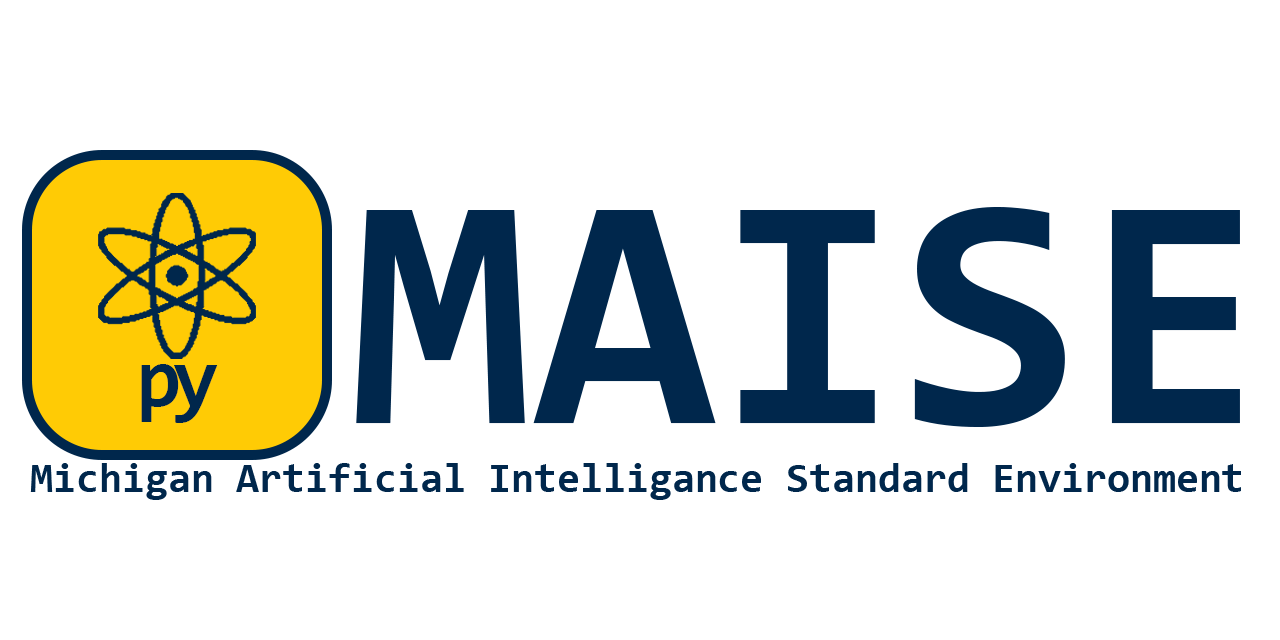